# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Project Overview

Sparkify is an online music streaming service that allows its users to listen and manage their favourite music. Sparkify offers its services in two tiers. The free tier where users can use Sparkify services for free but songs are interspersed with commercial breaks. The paid tier on the other hand is a premium service that plays ad free music at a monthly subscription fee.

Users can add songs to their play list, like or dislike songs, add other users as friends (possibly for sharing playlists) along with upgrading, downgrading or cancelling subscription. Each of the action taken by user is added to an event log which contains event type, timestamp of the event along with user name,  subscription tier and other event specific details.

Based on the usage pattern of users, Sparkify would like to predict if a user is at risk of leaving or downgrading their subscription. This will help them identify users who can be icentivised by means of discounts so that they stay.


## Problem Statement
Users cancelling the subscription or downgrading their account is a potential revenue loss. Sparkify would like to avoid and minimize users cancelling or downgrading the subscription.
The goal of this project is to apply data analysis and machine learning to predict if a user is at risk of cancelling the subscription. 

- The data is available in form of user events in json format
- Data needs pre-processing in form of
	- Clean up of missing or unusable data
	- Feature extraction to extract meaningful information
- The pre-processed data is then used to train several superwised machine learning model.
- The best suited model is then chosen to predict future data


In [1]:
# import libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, desc, asc
from pyspark.sql.functions import sum as Fsum, max as Fmax, min as Fmin, window, avg as Favg, count as Fcount, hour as Fhour, count as Fcount
from pyspark.sql.functions import datediff, lag, lit
from pyspark.sql.types import IntegerType, StringType, TimestampType

from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, DecisionTreeClassifier, NaiveBayes, MultilayerPerceptronClassifier


from pyspark.ml.evaluation import BinaryClassificationEvaluator

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

datafilePath = 'mini_sparkify_event_data.json'
processed_file_path = 'sparkify_processed_mini.json'

spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1561164994065'),
 ('spark.driver.port', '40363'),
 ('spark.driver.host', '78d69239707b'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
user_log = spark.read.json(datafilePath)
user_log.printSchema()
print((user_log.count(), len(user_log.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

(286500, 18)


In [4]:
user_log.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [5]:
no_user_or_session = user_log.filter((user_log.userId == '') | (user_log.sessionId == ''))
no_user_or_session.select('page').dropDuplicates().show()

print('Number of records having no userId or sessionId', no_user_or_session.count())
print('Number of records having sessionId but missing userId', no_user_or_session.filter((user_log.userId == '') & (user_log.sessionId != '')).count())
print('Number of records having userId but missing sessionId', no_user_or_session.filter((user_log.userId != '') & (user_log.sessionId == '')).count())

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+

Number of records having no userId or sessionId 8346
Number of records having sessionId but missing userId 0
Number of records having userId but missing sessionId 0


We see there are 8346 events without any _userId_ or _sessionId_ association. Looking at the _page_ column for these events it is evident that these records belong to unregistered users. 
We also see that for these records both sessionId and userId are missing so we can not backfill these records either. Also it appears that the _sessionId_ are rotated and can belong to different users over different period of time. Hence, we can not use _sessionId_ information to backfill the _userId_.

We can not extract meaningful insights from these records and we should drop these records from our analysis.

In [6]:
user_log_valid = user_log.dropna(how='any', subset=['userId', 'sessionId']);
user_log_valid = user_log_valid.where(user_log_valid.userId != '')

Let us extract 'state' information from **location**.

In [7]:
get_state = udf(lambda x: x[-2:])
user_log_valid = user_log_valid.withColumn('state', get_state(user_log_valid.location))

The **timestamp** information appears to be a long value since unix epoch and is difficult to interpret. Let's convert it into timestamp format.

In [8]:
get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0), TimestampType())
user_log_valid = user_log_valid.withColumn('timestamp', get_timestamp(user_log_valid.ts))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Let us see what other features the dataset contains:

In [9]:
count_by_page = user_log_valid.groupby('page').agg(Fcount('page').alias('cnt')).sort('page').toPandas()
count_by_gender = user_log_valid.groupby('gender').agg(Fcount('gender').alias('cnt')).sort('gender').toPandas()
count_by_level = user_log_valid.groupby('level').agg(Fcount('level').alias('cnt')).sort('level').toPandas()
count_by_status = user_log_valid.groupby('status').agg(Fcount('status').alias('cnt')).withColumn('status', col('status').cast(StringType())).sort('status').toPandas()

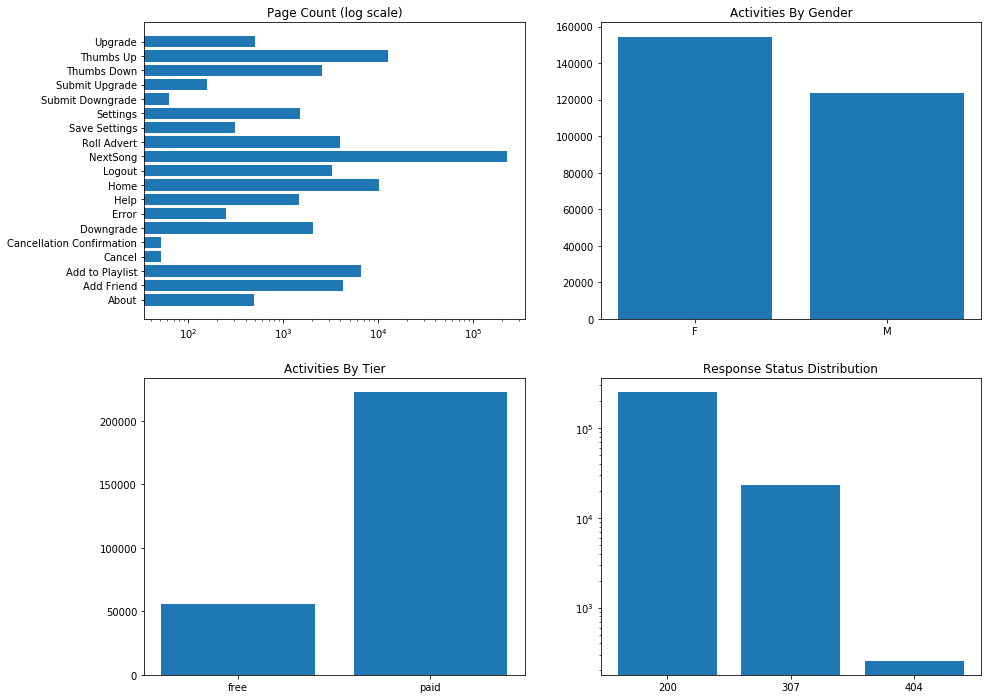

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15,12))

axs[0,0].barh(count_by_page.page, count_by_page.cnt, log=True)
axs[0,0].set_title('Page Count (log scale)')

axs[0,1].bar(count_by_gender.gender, count_by_gender.cnt)
axs[0,1].set_title('Activities By Gender')

axs[1,0].bar(count_by_level.level, count_by_level.cnt)
axs[1,0].set_title('Activities By Tier')

axs[1,1].bar(count_by_status.status, count_by_status.cnt, log=True)
axs[1,1].set_title('Response Status Distribution')

plt.show()

- **page** column represents the events initiated by users and can be used to extract meaningful features for modeling and analysis.
- **gender** split is roughly equal. We can see if there is a bias in churned users based on gender.
- **level** contains if user is on free tier or paid subscription. It appears that 'paid' users are much more active, however this difference could also be due to more number of paid users in the available dataset.
- **status** represents the HTTP response code received. 4xx error codes represent the error and we can see if receiving too many errors was a factor 

In [11]:
uid_reg_cnt = user_log_valid.select('userId', 'registration') \
                .dropDuplicates() \
                .groupBy('userId', 'registration') \
                .count().withColumnRenamed('count', 'cnt')
print('Num Records showing different registration value for same userId', uid_reg_cnt.where('cnt > 1  or cnt < 1').count())

Num Records showing different registration value for same userId 0


**registration** represents the registration time for the given user. There's one-to-one relationship between them. We can utilize this column to derive the user lifetime.

Let's evaluate **number of songs played by hour of day**

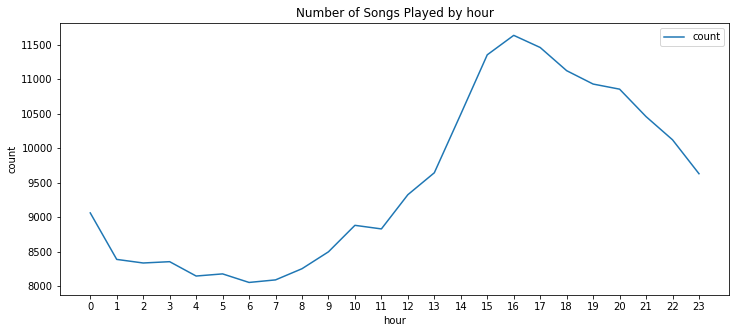

In [12]:
play_count_by_hour = user_log_valid.where(user_log_valid.page=='NextSong') \
                        .groupby(Fhour(user_log_valid.timestamp).alias('hour')) \
                        .count().orderBy('hour').toPandas()

ax = play_count_by_hour.plot(x='hour', title="Number of Songs Played by hour", xticks=range(0,24,1), figsize=(12,5))
ax.set(xlabel="hour", ylabel="count");

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

We define 'Churn' as any user who cancels the services (occurance of 'Cancellation Confirmation' event). Let us mark our data with additional 'churned' column having value 1 for users who ever churned and 0 otherwise.
We also create a 'phase' column that has value 0 for events before user decides to downgrade services and 1 afterwards.

In [13]:
churn_func = udf(lambda x: 'churned' if x == 1 else 'active')
# create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

windowVal = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)
user_log_valid = user_log_valid.withColumn('phase', Fsum('downgraded').over(windowVal))

flag_cancelled_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log_valid = user_log_valid.withColumn('cancelled', flag_cancelled_event(user_log_valid.page))

# mark user who've ever downgraded as churn
windowval = Window.partitionBy('userId')
user_log_valid = user_log_valid.withColumn('churned', churn_func(Fmax('cancelled').over(windowval)))

In [14]:
user_log_valid.select(['userId', 'downgraded', 'phase', 'cancelled', 'churned']).take(5)

[Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active'),
 Row(userId='100010', downgraded=0, phase=0, cancelled=0, churned='active')]

### Explore Churn
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
churned_split = user_log_valid.select(['userId', 'churned']) \
                    .dropDuplicates() \
                    .groupby('churned') \
                    .agg(Fcount('churned').alias('cnt'))\
                    .sort('churned') \
                    .toPandas()

churn_by_gender = user_log_valid.select(['gender', 'userId', 'churned']) \
                    .dropDuplicates() \
                    .groupby('churned', 'gender') \
                    .count().withColumnRenamed('count', 'cnt') \
                    .toPandas() \
                    .pivot(index='churned', columns='gender')['cnt']

churn_by_state = user_log_valid.where(user_log_valid.page=='Cancellation Confirmation') \
                    .select(['userId', 'state']) \
                    .groupBy('state') \
                    .count().withColumnRenamed('count', 'cnt') \
                    .toPandas()

w = Window.partitionBy('userId')
churn_by_tier = user_log_valid.withColumn('maxTs', Fmax('ts').over(w))\
                    .where(col('ts') == col('maxTs'))\
                    .drop('maxTs')\
                    .select('userId', 'churned', 'level') \
                    .dropDuplicates() \
                    .groupby('churned', 'level') \
                    .count().withColumnRenamed('count', 'cnt') \
                    .toPandas() \
                    .pivot(index='churned', columns='level')['cnt']

user_ad_count = user_log_valid.where(user_log_valid.page=='Roll Advert') \
                    .groupBy('churned') \
                    .count() \
                    .withColumnRenamed('count', 'adCount') \
                    .sort('churned') \
                    .toPandas() \
                    .merge(churned_split)
user_ad_count['avg_count'] = user_ad_count.adCount/user_ad_count.cnt

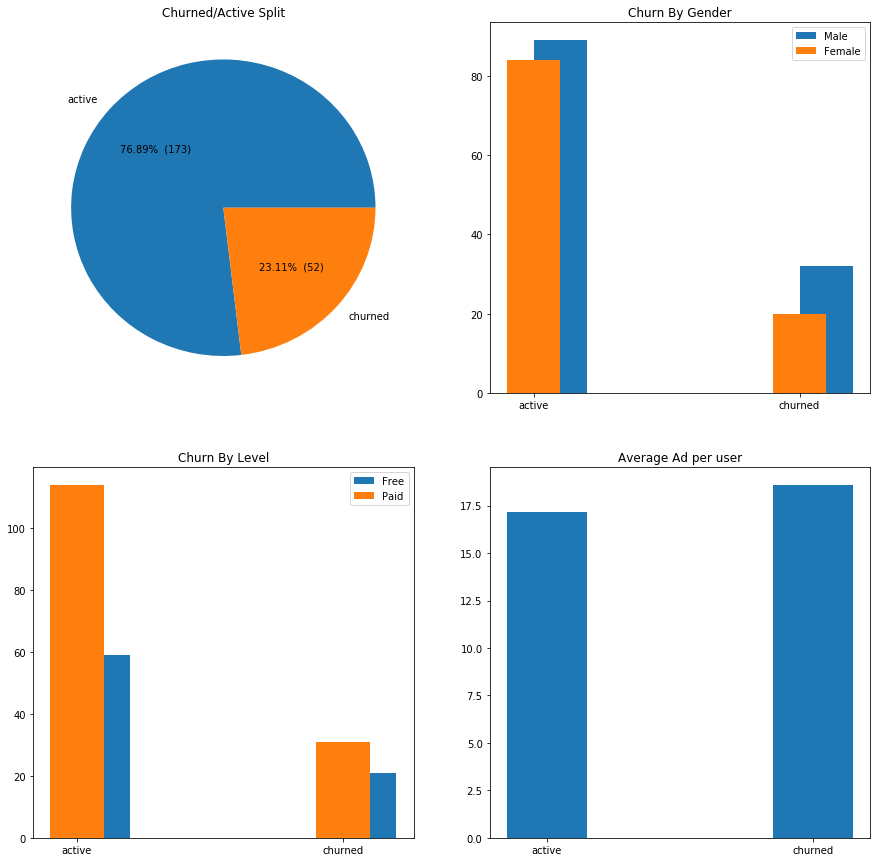

In [16]:
#https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


fig, axs = plt.subplots(2,2, figsize=(15,15))

axs[0,0].pie( churned_split.cnt, labels=churned_split.churned, autopct=make_autopct(churned_split.cnt))
axs[0,0].set_title('Churned/Active Split')
axs[1, 0].legend(loc='upper right')

#axs[0,0].set_xticks([0,1])

axs[0,1].bar([str(i) for i in churn_by_gender.index], churn_by_gender.M, label="Male", align='edge', width=0.2)
axs[0,1].bar([str(i) for i in churn_by_gender.index], churn_by_gender.F, label="Female", align='center', width=0.2)
axs[0,1].set_title('Churn By Gender')
axs[0,1].legend(loc='upper right')

axs[1, 0].bar([str(i) for i in churn_by_tier.index], churn_by_tier.free, label="Free", align='edge', width=0.2)
axs[1, 0].bar([str(i) for i in churn_by_tier.index], churn_by_tier.paid, label="Paid", align='center', width=0.2)
axs[1, 0].set_title('Churn By Level')
axs[1, 0].legend(loc='upper right')


axs[1,1].bar(user_ad_count.churned, user_ad_count.avg_count, width=.3)
axs[1,1].set_title('Average Ad per user')

plt.show()

- Out of total 225 records, 52 churned and 173 remained subscribed.
- Churn is slightly higher for male users.
- Higher proportion of paid users remained active compared to free users.
- Average number of ads seen by churned users is marginally higher compared to active users.

### Examin Churn by location

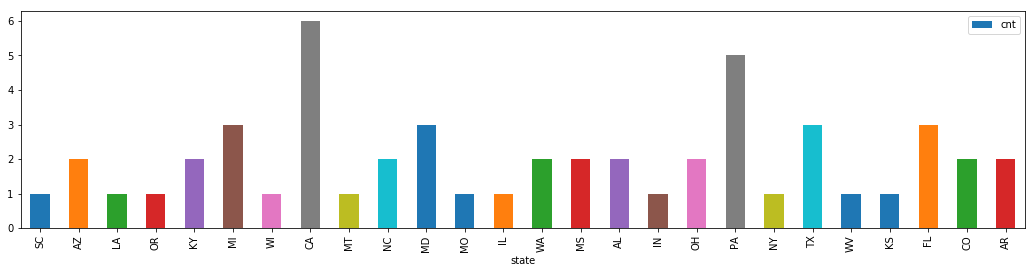

In [17]:
churned_users = user_log_valid.where(user_log_valid.churned=='churned')\
                    .select('userId','state')\
                    .dropDuplicates() \
                    .groupBy('state')\
                    .agg(Fcount('state').alias('cnt')).toPandas()
churned_users.plot(kind='bar',x='state', y='cnt', figsize=(18,4));

We see spikes for certain states. However, since overall counts are low (min 1 and max 6), we can not conclude any state bias on the churn.

### Examin number of songs

In [18]:
weekly_songs_played = user_log_valid.where(user_log_valid.page=='NextSong').select(['timestamp', 'churned'])
weekly_songs_played = weekly_songs_played.groupBy(window(weekly_songs_played.timestamp,"1 week"), 'churned').count()
df = weekly_songs_played.select('window.start','churned','count').withColumnRenamed('count', 'cnt').toPandas()

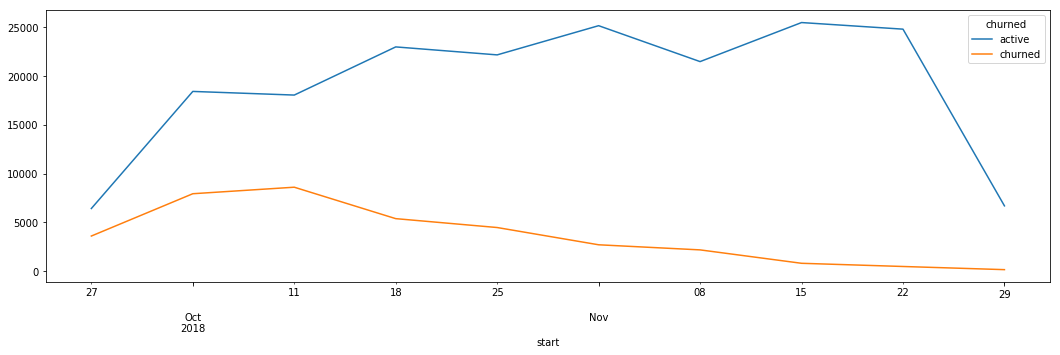

In [19]:
ax = df.pivot(index='start', columns='churned')['cnt'].plot(kind='line', figsize=(18,5))

- number of songs played by churned users are low and they slowly go down over the period of time
- number of songs played by active users more or less remain constant

### Examin errors encountered

In [20]:
churn_by_errors = user_log_valid.where(user_log_valid.page=='Error') \
                    .select('churned') \
                    .groupBy('churned') \
                    .count() \
                    .withColumnRenamed('count', 'numErrors') \
                    .sort('churned') \
                    .toPandas() \
                    .merge(churned_split)
churn_by_errors['avg_errors'] = churn_by_errors.numErrors/churn_by_errors.cnt
churn_by_errors

,churned,numErrors,cnt,avg_errors
0,active,220,173,1.271676
1,churned,32,52,0.615385


- Proportionately, error page faced by active users is higher than the errors faced by users who cancelled subscription.
- we don't think that to be an impact on user's decision. Neverthless we should consider it in our modeling.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### User Lifetime

In [21]:
# Extract lifetime since registration
user_lifetime = user_log_valid.select('userId','ts','registration').groupBy('userId', 'registration').agg((Fmax(user_log_valid.ts - user_log_valid.registration)/(1000*3600*24)).alias('lifetime')).select(['userId', 'lifetime'])

#### Session Count, Average, Minimum and Maximum Session Duration

In [22]:
# Session Count, Average, Minimum and Maximum Session Duration
user_session_info = user_log_valid.groupBy('userId', 'sessionId').agg((Fmax(user_log_valid.ts)-Fmin(user_log_valid.ts)).alias('duration'))
user_session_info = user_session_info.groupBy('userId').agg(Fcount('sessionId').alias('sessionCount'), Favg('duration').alias('averageSessionDuration'), Fmax('duration').alias('maxSessionDuration'), Fmin('duration').alias('minSessionDuration'))

#### Number of songs played per session

In [23]:
# Number of songs played per session
user_avg_songs = user_log_valid.where(user_log_valid.page=='NextSong').groupBy('userId', 'sessionId').count()
user_avg_songs = user_avg_songs.groupBy('userId').agg(Favg('count').alias('songsPerSession'))

#### Number of songs added to playlist

In [24]:
user_playlist_count = user_log_valid.where(user_log_valid.page=='Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'playlistCount')

#### Number of Errors encountered

In [25]:
user_error_count = user_log_valid.where(user_log_valid.page=='Error').groupBy('userId').count().withColumnRenamed('count', 'errorCount')

#### Number of Advertisements seen

In [26]:
user_ad_count = user_log_valid.where(user_log_valid.page=='Roll Advert').groupBy('userId').count().withColumnRenamed('count', 'adCount')

#### Number of friends added

In [27]:
user_friends_count = user_log_valid.where(user_log_valid.page=='Add Friend').groupBy('userId').count().withColumnRenamed('count', 'friendCount')

#### Number of Thumbs Up and Thumbs Down events

In [28]:
user_thumbsup_count = user_log_valid.where(user_log_valid.page=='Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'thumbsUpCount')
user_thumbsdown_count = user_log_valid.where(user_log_valid.page=='Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'thumbsDownCount')

#### Songs Skip Forwarded

Assuming users are recommended next song by recommendation engine, the percentage length of song listened by user could be a good indicator of effectiveness of our recommendation engine. The dataset provides the length of song in seconds.
We can compute the difference in event timestamps (next event's timestamp minus current event's timestamp) to see how long user listened to the song.
Longer the user stays on the current song before moving onto the next one, better the effectiveness of recommendation and higher the chances of retaining users.

In [29]:
w = Window().partitionBy("userId","sessionId").orderBy("timestamp")

df_lag = user_log_valid.withColumn('next_ts',
                        lag(user_log_valid['ts'], -1)
                                 .over(w))

user_log_valid = df_lag.withColumn('play_duration', 
          (df_lag['next_ts']-df_lag['ts'])/(df_lag['length']*1000) )

user_avg_listen_length = user_log_valid.where(user_log_valid.page=='NextSong').groupBy('userId').agg(Favg('play_duration').alias('avg_listen_length'))

#### Gender and Tier information

In [30]:
level_mapper = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

w = Window.partitionBy('userId')
user_current_level = user_log_valid.withColumn('maxTs', Fmax('ts').over(w))\
    .where(col('ts') == col('maxTs'))\
    .drop('maxTs')\
    .select('userId', 'level').dropDuplicates()

user_current_level = user_current_level.withColumn('level', level_mapper(user_current_level.level))


In [31]:
gender_mapper = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
churn_mapper = udf(lambda x: 1 if x == 'churned' else 0, IntegerType())

users = user_log_valid.select('userId', churn_mapper('churned').alias('label'), gender_mapper('gender').alias('gender')) \
            .dropDuplicates()

data_ml = users.join(user_lifetime, on='userId', how='left')\
        .join(user_session_info, on='userId', how='left')\
        .join(user_avg_songs, on='userId', how='left')\
        .join(user_playlist_count, on='userId', how='left')\
        .join(user_error_count, on='userId', how='left')\
        .join(user_ad_count, on='userId', how='left')\
        .join(user_friends_count, on='userId', how='left')\
        .join(user_thumbsup_count, on='userId', how='left')\
        .join(user_thumbsdown_count, on='userId', how='left')\
        .join(user_avg_listen_length, on='userId', how='left')\
        .join(user_current_level, on='userId', how='left')\
        .drop('userId') \
        .fillna(0)

# A Note on Last operation 'fillna' above
# if users have not performed a certain action e.g. add-to-playlist or thumbs-up/thumbs-down,
# the corresponding value will be left NULL by left join. 
# This effect is seen in engineered count and average columns. We can safely fill these values to 0

#### A Note on Last operation 'fillna' above
If users have not performed a certain action e.g. add-to-playlist or thumbs-up/thumbs-down, the corresponding value will be left NULL by left join. This effect is seen in engineered count and average columns. We can safely fill these values to 0

In [32]:
data_ml.printSchema()

root
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- lifetime: double (nullable = false)
 |-- sessionCount: long (nullable = true)
 |-- averageSessionDuration: double (nullable = false)
 |-- maxSessionDuration: long (nullable = true)
 |-- minSessionDuration: long (nullable = true)
 |-- songsPerSession: double (nullable = false)
 |-- playlistCount: long (nullable = true)
 |-- errorCount: long (nullable = true)
 |-- adCount: long (nullable = true)
 |-- friendCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- avg_listen_length: double (nullable = false)
 |-- level: integer (nullable = true)



In [33]:
data_ml.write.save(processed_file_path, format="json", mode="overwrite")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [34]:
data_ml = spark.read.json(processed_file_path)

### Choosing the evaluation metric

As this is a binary classification problem, we should consider accuracy, precision, recall, f1 score or Area Under ROC curve as our possible evaluation metrics.

**accuracy** and **Area under ROC** work best when our _labels_ are balanced. Our target variable 'churned' is skewed having 76% negative and 24% positive cases. Hence we can not use _accuracy_ or _Area under ROC_ as our metric.

 

In [35]:
def get_metrics(df):
    TP = df[(df.label==1) & (df.prediction==1)].shape[0]
    TN = df[(df.label==0) & (df.prediction==0)].shape[0]
    FP = df[(df.label==0) & (df.prediction==1)].shape[0]
    FN = df[(df.label==1) & (df.prediction==0)].shape[0]
    accuracy = (TP+TN)/(TP + TN + FP + FN)
    precision = 0 if (TP+FP)==0 else TP/(TP+FP)
    recall = 0 if (TP+FN)==0 else TP/(TP+FN)
    specificity =  0 if (TN+FP)==0 else TN/(TN+FP)
    f1_score = 0 if (precision + recall)==0 else (2*precision*recall) / (precision + recall)
    return {'accuracy': accuracy, 'precision':precision, 'recall': recall, 'specificity': specificity, 'f1_score': f1_score}

df = data_ml.select('label').toPandas()
df['prediction'] = 0
results0 = get_metrics(df)

df['prediction'] = 1
results1 = get_metrics(df)

print('======================Naive Prediction Scores======================')
print('Predict No Churning:\n', results0)
print('Predict Everybody as Churned:\n', results1)


======================Naive Prediction Scores======================
Predict No Churning:
 {'accuracy': 0.7688888888888888, 'precision': 0, 'recall': 0.0, 'specificity': 1.0, 'f1_score': 0}
Predict Everybody as Churned:
 {'accuracy': 0.2311111111111111, 'precision': 0.2311111111111111, 'recall': 1.0, 'specificity': 0.0, 'f1_score': 0.37545126353790614}


We should attempt to catch as many churned users as possible, since we do not want those users to leave our site. However, classifying everybody as 'churned' would be counter productive as Sparkify would end up offering discounts to all users resulting in revenue loss.

We must try to maximize both _Precision and Recall_ scores. A balancing F1 score appears to be the best measure of scoring our model.

Our naive predictions gave f1 score of 0 (when predicting no churning) and ~0.38 when predicting complete churn. Let us apply supervised learning techniques to see if we can have a model with better prediction than this.

### Vectorize and Scale

In [36]:
#data_ml = spark.read.json(processed_file_path)
feature_columns = [col for col in data_ml.columns if col!='label']

assembler = VectorAssembler(inputCols=feature_columns, outputCol='FeatureVector')

data_ml = assembler.transform(data_ml)

scaler = StandardScaler(inputCol="FeatureVector", outputCol="features", withStd=True)
train, test = data_ml.randomSplit([0.7, 0.3], seed=42)

scalerModel = scaler.fit(train)
train = scalerModel.transform(train).select(col('features'), col('label')).persist()
test = scalerModel.transform(test).select(col('features'), col('label')).persist()

In [37]:
from pyspark.ml.evaluation import Evaluator
import random

class F1ScoreEvaluator(Evaluator):

    def __init__(self, predictionCol="prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        """
        Returns a random number. 
        Implement here the true metric
        """
        score = get_metrics(dataset.select('label', 'prediction').toPandas())['f1_score']
        return score

    def isLargerBetter(self):
        return True

In [38]:
def train_model(train_data, test_data, estimator, paramGrid=None):
    estimatorName = estimator.__class__.__name__
    evaluator = F1ScoreEvaluator() #BinaryClassificationEvaluator(metricName="areaUnderPR")
    if paramGrid != None:
        estimator = CrossValidator(estimator=estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
      
    model = estimator.fit(train_data)
    train_pred = model.transform(train_data)
    test_pred = model.transform(test_data)
    train_f1 = evaluator.evaluate(train_pred);
    test_f1 = evaluator.evaluate(test_pred);
    result = {'estimator': estimatorName, 'train_f1':train_f1, 'test_f1':test_f1, 'model': model}
    return result


Let us evaluate several machine learning models for f1 score. We will choose promising models and further optimize these models.

{'estimator': 'LogisticRegression', 'train_f1': 0.6, 'test_f1': 0.4375, 'model': LogisticRegressionModel: uid = LogisticRegression_0c2a914b09ea, numClasses = 2, numFeatures = 15}
{'estimator': 'RandomForestClassifier', 'train_f1': 0.7450980392156863, 'test_f1': 0.32000000000000006, 'model': RandomForestClassificationModel (uid=RandomForestClassifier_71f871d51a39) with 20 trees}
{'estimator': 'LinearSVC', 'train_f1': 0, 'test_f1': 0, 'model': LinearSVC_8b32e2839610}
{'estimator': 'GBTClassifier', 'train_f1': 1.0, 'test_f1': 0.5555555555555556, 'model': GBTClassificationModel (uid=GBTClassifier_2a8a6d9aa855) with 20 trees}
{'estimator': 'DecisionTreeClassifier', 'train_f1': 0.8571428571428571, 'test_f1': 0.5555555555555556, 'model': DecisionTreeClassificationModel (uid=DecisionTreeClassifier_171af8831fc3) of depth 5 with 27 nodes}
{'estimator': 'NaiveBayes', 'train_f1': 0.2978723404255319, 'test_f1': 0.2222222222222222, 'model': NaiveBayes_721cc5fcbe33}


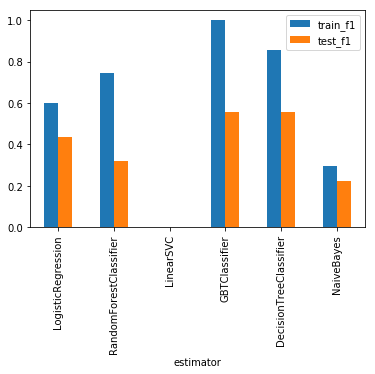

In [39]:
results = []
all_algo = [LogisticRegression(), RandomForestClassifier(), LinearSVC(), GBTClassifier(), DecisionTreeClassifier(), NaiveBayes()]

for algo in all_algo:
    result = train_model(train, test, algo, None)
    print(result)
    results.append(result)
    
pd.DataFrame(results).plot(kind='bar', x='estimator', y=['train_f1', 'test_f1']);


- **LogisticRegression** has consistent F1 score between train and test sets
- **GBTClassifier** and **DecisionTreeClassifier** both have high training F1 score and better test scores compared to **RandomForestClassfier**.
- **NaiveBayes** shows very poor training and testing scores.
- **LinearSVC** shows AreaUnderPRCurve around ~0.56-0.58 but F1 score is 0. We can improve F1 score somewhat by tuning threshold.

In [40]:
tunedResults=[]

In [41]:
# LogisticRegression, 
algo = LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(algo.regParam,[0.0, 0.1, 0.5]) \
    .addGrid(algo.aggregationDepth, [2, 3, 4]) \
    .build()

result = train_model(train, test, algo, paramGrid)
print(result)
tunedResults.append(result)

{'estimator': 'LogisticRegression', 'train_f1': 0.6, 'test_f1': 0.4375, 'model': CrossValidatorModel_48c43d3a27c0}


In [42]:
algo = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(algo.maxDepth,[2, 3, 5, 7]) \
    .addGrid(algo.maxBins, [4, 8, 16, 32]) \
    .build()

result = train_model(train, test, algo, paramGrid)

print(result)
tunedResults.append(result)

{'estimator': 'DecisionTreeClassifier', 'train_f1': 0.9393939393939394, 'test_f1': 0.37837837837837834, 'model': CrossValidatorModel_689a89820d49}


In [43]:
algo = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(algo.maxDepth,[2, 3, 5]) \
    .addGrid(algo.maxBins, [8, 16, 32]) \
    .build()

result = train_model(train, test, algo, paramGrid)

print(result)
tunedResults.append(result)

{'estimator': 'GBTClassifier', 'train_f1': 0.8620689655172413, 'test_f1': 0.4117647058823529, 'model': CrossValidatorModel_20dba60c7dda}


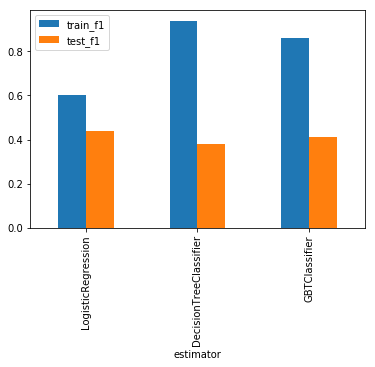

In [44]:
pd.DataFrame(tunedResults).plot(kind='bar', x='estimator', y=['train_f1', 'test_f1']);

GBTClassifier shows the best results. This still seems to be overfitting and the F1-score on test data is not as good. We should consider engineering more relevant features and time-chunk the features to see if the trend over period provides better indication of user churn.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Reflection

- After feature engineering, I used the same dataframe for further test/train split and subsequent model training. It was taking long time even for small amount of data. It seems very obvious now but it was interesting to realize that since Spark procastinates the operations on DataFrames, training iterations were taking long as entire transformation pipeline was run everytime. Persisting the dataset with engineered features and reloading it quickened up the model training.

## Further Improvements

- Several features like average session duration, songs listened per session have been averaged out for entire period. Splitting it 'week on week' could reveal interesting trends, as a shrinking session duration over the period may be a better indicator of users prone to churn. This may also improve accuracy of model.

- Additional information about user profile like user's age group, interests if made available, could have been very useful.
- We can derive the song genre based on title and external lookup. If users liking a particular genre are churning more, this could indicate issues with out recommendation engine.